# End-to-end Masked Language Modeling with BERT

**Author:** [Ankur Singh](https://twitter.com/ankur310794)<br>
**Date created:** 2020/09/18<br>
**Last modified:** 2024/03/15<br>
**Description:** Implement a Masked Language Model (MLM) with BERT and fine-tune it on the IMDB Reviews dataset.

---

EQUIPE:

* Ana Carolina Aguiar - Mat.: 20210024326
* Cassiano Sabino - Mat.: 20210025806
* Geovana Lima - Mat.: 20210024729

---

## Introduction

Masked Language Modeling is a fill-in-the-blank task,
where a model uses the context words surrounding a mask token to try to predict what the
masked word should be.

For an input that contains one or more mask tokens,
the model will generate the most likely substitution for each.

Example:

- Input: "I have watched this [MASK] and it was awesome."
- Output: "I have watched this movie and it was awesome."

Masked language modeling is a great way to train a language
model in a self-supervised setting (without human-annotated labels).
Such a model can then be fine-tuned to accomplish various supervised
NLP tasks.

This example teaches you how to build a BERT model from scratch,
train it with the masked language modeling task,
and then fine-tune this model on a sentiment classification task.

We will use the Keras `TextVectorization` and `MultiHeadAttention` layers
to create a BERT Transformer-Encoder network architecture.

Note: This example should be run with `tf-nightly`.

---

EQUIPE:

⇒ Para o nosso projeto, construímos um modelo BERT do zero, treinamos com Masked Language Modeling (MLM) e realizamos o fine-tuning em uma tarefa de classificação hierárquica de artigos da Wikipédia com base no dataset [DBpedia](https://www.kaggle.com/datasets/danofer/dbpedia-classes?select=DBP_wiki_data.csv).

---

## Setup

Install `tf-nightly` via `pip install tf-nightly`.

---

EQUIPE:

⇒ Mantivemos o mesmo setup do notebook original.

---

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # or jax, or tensorflow

import keras_hub

import keras
from keras import layers
from keras.layers import TextVectorization

from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

## Set-up Configuration

In [2]:

@dataclass
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 30000
    EMBED_DIM = 128
    NUM_HEAD = 8  # used in bert model
    FF_DIM = 128  # used in bert model
    NUM_LAYERS = 1


config = Config()

## Load the data

We will first download the IMDB data and load into a Pandas dataframe.

---

EQUIPE:

⇒ Aqui, fizemos o download dos dados do DBPedia, do Kaggle, e carregamos para um dataframe do Pandas.

---

In [3]:
!curl -L -o dbpedia-classes.zip https://www.kaggle.com/api/v1/datasets/download/danofer/dbpedia-classes

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  165M  100  165M    0     0  17.2M      0  0:00:09  0:00:09 --:--:-- 22.0M


In [4]:
!unzip dbpedia-classes.zip

Archive:  dbpedia-classes.zip
  inflating: DBPEDIA_test.csv        
  inflating: DBPEDIA_train.csv       
  inflating: DBPEDIA_val.csv         
  inflating: DBP_wiki_data.csv       


In [5]:
train_df = pd.read_csv("/content/DBPEDIA_train.csv")
test_df = pd.read_csv("/content/DBPEDIA_test.csv")

---

EQUIPE:

⇒ Fizemos o drop das colunas l2 e l3, que constituem as labels de classificação entre 70 e 219 classes, respectivamente. Neste notebook, vamos nos concentrar no treinamento do modelo com 9 classes, referente à coluna l1 do dataframe.

---

In [6]:
train_df.drop(columns=["l2", "l3"])
test_df.drop(columns=["l2", "l3"])

,text,l1
0,Liu Chao-shiuan (Chinese: 劉兆玄; pinyin: Liú Zhà...,Agent
1,"Michelle Maylene (born January 20, 1987) is an...",Agent
2,Hirfanlı Dam is a dam in Turkey. The developme...,Place
3,Grote Prijs Stad Zottegem is a single-day road...,Event
4,"Johannes Petrus \""Hans\"" Nijman (September 23,...",Agent
...,...,...
60789,Darwin Smith was CEO of Kimberly-Clark from 19...,Agent
60790,The HKRU Premiership is the main domestic comp...,Agent
60791,"Leo Harvey Diegel (April 20, 1899 – May 5, 195...",Agent
60792,"Clement Reginald \""Clem\"" Splatt (17 September...",Agent


---

EQUIPE:

⇒ Renomeamos as colunas para usarmos o padrão "text" e "label".

---

In [7]:
train_df = train_df.rename(columns={"text": "text", "l1": "label"})
test_df = test_df.rename(columns={"text": "text", "l1": "label"})

In [8]:
all_data = pd.concat([train_df, test_df], ignore_index=True)

## Dataset preparation

We will use the `TextVectorization` layer to vectorize the text into integer token ids.
It transforms a batch of strings into either
a sequence of token indices (one sample = 1D array of integer token indices, in order)
or a dense representation (one sample = 1D array of float values encoding an unordered set of tokens).

Below, we define 3 preprocessing functions.

1.  The `get_vectorize_layer` function builds the `TextVectorization` layer.
2.  The `encode` function encodes raw text into integer token ids.
3.  The `get_masked_input_and_labels` function will mask input token ids.
It masks 15% of all input tokens in each sequence at random.



---


EQUIPE:

⇒ Utilizamos as mesmas funções de pré-processamento para preparar os textos do dataset para serem:

* Codificados como sequências de inteiros (tokens).
* Mascarados parcialmente para treinar o modelo com MLM.
* Organizados em conjuntos de treino/teste para classificação supervisionada.

⇒ Do BERT:
* 15% dos tokens são escolhidos para mascaramento.
* Dos tokens escolhidos:
    - 80% viram `[MASK]`
    - 10% viram tokens aleatórios
    - 10% permanecem inalterados

Isso ajuda o modelo a aprender contexto, não apenas prever `[MASK]`.

⇒ Foram construídos os seguintes datasets:
* `train_classifier_ds`: textos vetorizados + rótulos para treino
* `test_classifier_ds`: textos vetorizados + rótulos para teste
* `mlm_ds`: textos com tokens mascarados, rótulos verdadeiros e pesos de amostra


---



In [9]:
# For data pre-processing and tf.data.Dataset
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder


def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), ""
    )


def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):
    """Build Text vectorization layer

    Args:
      texts (list): List of string i.e input texts
      vocab_size (int): vocab size
      max_seq (int): Maximum sequence length.
      special_tokens (list, optional): List of special tokens. Defaults to ['[MASK]'].

    Returns:
        layers.Layer: Return TextVectorization Keras Layer
    """
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )
    vectorize_layer.adapt(texts)

    # Insert mask token in vocabulary
    vocab = vectorize_layer.get_vocabulary()
    vocab = vocab[2 : vocab_size - len(special_tokens)] + ["[mask]"] # Why is this hardcoded????
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer


vectorize_layer = get_vectorize_layer(
    all_data.text.values.tolist(),
    config.VOCAB_SIZE,
    config.MAX_LEN,
    special_tokens=["[mask]"],
)

# Get mask token id for masked language model
mask_token_id = vectorize_layer(["[mask]"]).cpu().numpy()[0][0]


def encode(texts):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.cpu().numpy()


def get_masked_input_and_labels(encoded_texts):
    # 15% BERT masking
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    # Do not mask special tokens
    inp_mask[encoded_texts <= 2] = False
    # Set targets to -1 by default, it means ignore
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    # Set labels for masked tokens
    labels[inp_mask] = encoded_texts[inp_mask]

    # Prepare input
    encoded_texts_masked = np.copy(encoded_texts)
    # Set input to [MASK] which is the last token for the 90% of tokens
    # This means leaving 10% unchanged
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[inp_mask_2mask] = (
        mask_token_id  # mask token is the last in the dict
    )

    # Set 10% to a random token
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )

    # Prepare sample_weights to pass to .fit() method
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    # y_labels would be same as encoded_texts i.e input tokens
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels, sample_weights

label_encoder = LabelEncoder()

# We have 25000 examples for training
x_train = encode(train_df.text.values)  # encode reviews with vectorizer
y_train = train_df.label.values
y_train_encoded = label_encoder.fit_transform(train_df['label'].values).astype(float)
train_classifier_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train_encoded))
    .shuffle(1000)
    .batch(config.BATCH_SIZE)
)

# We have 25000 examples for testing
x_test = encode(test_df.text.values)
y_test = test_df.label.values

# Transforma os rótulos do teste (usando o mesmo codificador)
y_test_encoded = label_encoder.transform(test_df['label'].values).astype(float)
test_classifier_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_encoded)).batch(
    config.BATCH_SIZE
)

# Dataset for end to end model input (will be used at the end)
test_raw_classifier_ds = test_df

# Prepare data for masked language model
x_all_review = encode(all_data.text.values)
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(
    x_all_review
)

mlm_ds = tf.data.Dataset.from_tensor_slices(
    (x_masked_train, y_masked_labels, sample_weights)
)
mlm_ds = mlm_ds.shuffle(1000).batch(config.BATCH_SIZE)

Instructions for updating:
Use tf.identity with explicit device placement instead.


## Create BERT model (Pretraining Model) for masked language modeling

We will create a BERT-like pretraining model architecture
using the `MultiHeadAttention` layer.
It will take token ids as inputs (including masked tokens)
and it will predict the correct ids for the masked input tokens.

---

EQUIPE:

⇒ A função `bert_module` implementa um bloco codificador (encoder) da arquitetura Transformer. Cada encoder contém:

* Multi-Head Self Attention: o modelo aprende a prestar atenção em diferentes partes da sequência.
* Skip Connection + Normalização: adiciona o residual (skip-connection) e normaliza. Ajuda no fluxo de gradiente.
* Feed-forward (FFN): rede neural simples para transformar as representações.
* Skip Connection + Normalização novamente.

⇒ A `MaskedLanguageModel` é uma subclasse do `keras.Model` que calcula a loss de classificação por token mascarado (SparseCategoricalCrossentropy), reporta a loss média, e garante que o Keras possa resetar o estado da métrica automaticamente.

⇒ Já a função `create_masked_language_bert_model()` monta o modelo inteiro com
input layer (tokens inteiros de tamanho fixo) e embedding de palavras + posições e blocos `bert_module`.

⇒ No `MaskedTextGenerator` está o callback para acompanhar o desempenho do modelo após cada época.

---

In [10]:

def bert_module(query, key, value, i):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}_multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}_att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}_ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}_ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


loss_fn = keras.losses.SparseCategoricalCrossentropy(reduction=None)
loss_tracker = keras.metrics.Mean(name="loss")


class MaskedLanguageModel(keras.Model):

    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):

        loss = loss_fn(y, y_pred, sample_weight)
        loss_tracker.update_state(loss, sample_weight=sample_weight)
        return keras.ops.sum(loss)

    def compute_metrics(self, x, y, y_pred, sample_weight):

        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker]


def create_masked_language_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")

    word_embeddings = layers.Embedding(
        config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding"
    )(inputs)
    position_embeddings = keras_hub.layers.PositionEmbedding(
        sequence_length=config.MAX_LEN
    )(word_embeddings)
    embeddings = word_embeddings + position_embeddings

    # TODO: Discover what the fuck this do
    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i)

    mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(
        encoder_output
    )
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")

    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model


id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}


class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens)

        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[1]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        values = mask_prediction[0][top_indices]

        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            tokens = np.copy(sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": self.decode(sample_tokens[0].cpu().numpy()),
                "prediction": self.decode(tokens),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens(p),
            }
            pprint(result)


sample_tokens = vectorize_layer(["The [mask] of the article is unknown."])
generator_callback = MaskedTextGenerator(sample_tokens.cpu().numpy())

bert_masked_model = create_masked_language_bert_model()
bert_masked_model.summary()

Model: "masked_bert_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_embedding      │ (None, 256, 128)  │  3,840,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, 256, 128)  │     32,768 │ word_embedding[0… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 128)  │          0 │ word_embedding[0… │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_multihea… │ (None, 256, 128)  │     66,048 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0],        │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_drop… │ (None, 256, 128)  │          0 │ encoder_0_multih… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 128)  │          0 │ add[0][0],        │
│                     │                   │            │ encoder_0_att_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_laye… │ (None, 256, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn       │ (None, 256, 128)  │     33,024 │ encoder_0_att_la… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_drop… │ (None, 256, 128)  │          0 │ encoder_0_ffn[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256, 128)  │          0 │ encoder_0_att_la… │
│                     │                   │            │ encoder_0_ffn_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_laye… │ (None, 256, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlm_cls (Dense)     │ (None, 256,       │  3,870,000 │ encoder_0_ffn_la… │
│                     │ 30000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,842,352 (29.92 MB)

 Trainable params: 7,842,352 (29.92 MB)

 Non-trainable params: 0 (0.00 B)

## Train and Save

In [ ]:
bert_masked_model.fit(mlm_ds, epochs=5, callbacks=[generator_callback])
bert_masked_model.save("bert_mlm_dbpedia.keras")

## Fine-tune a sentiment classification model

We will fine-tune our self-supervised model on a downstream task of sentiment classification.
To do this, let's create a classifier by adding a pooling layer and a `Dense` layer on top of the
pretrained BERT features.

---

EQUIPE:

⇒ Aqui, estamos carregando um modelo BERT treinado com Masked Language Modeling (MLM) e usando sua saída como base (congelada) para um classificador. Então, adicionamos camadas extras para transformar embeddings do BERT em previsões de classes, treinando primeiro só o classificador, com o BERT congelado, depois, liberando o BERT para fine-tuning, e continuando o treinamento.

---

In [12]:
# Load pretrained bert model
mlm_model = keras.models.load_model(
    "bert_mlm_dbpedia.keras", custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)
pretrained_bert_model = keras.Model(
    mlm_model.input, mlm_model.get_layer("encoder_0_ffn_layernormalization").output
)

# Freeze it
pretrained_bert_model.trainable = False


def create_classifier_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")

    sequence_output = pretrained_bert_model(inputs)
    pooled_output = layers.GlobalMaxPooling1D()(sequence_output)
    hidden_layer = layers.Dense(64, activation="relu")(pooled_output)

    num_classes = len(label_encoder.classes_)
    outputs = layers.Dense(num_classes, activation="softmax")(hidden_layer)

    classifer_model = keras.Model(inputs, outputs, name="classification")
    optimizer = keras.optimizers.Adam()
    classifer_model.compile(
      optimizer=keras.optimizers.Adam(),
      loss="sparse_categorical_crossentropy",
      metrics=["accuracy"],
    )
    return classifer_model


classifer_model = create_classifier_bert_model()
classifer_model.summary()

# Train the classifier with frozen BERT stage
classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

# Unfreeze the BERT model for fine-tuning
pretrained_bert_model.trainable = True
optimizer = keras.optimizers.Adam()
classifer_model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

Model: "classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 256, 128)       │     3,972,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,981,193 (15.19 MB)

 Trainable params: 8,841 (34.54 KB)

 Non-trainable params: 3,972,352 (15.15 MB)

Epoch 1/5
7530/7530 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.7916 - loss: 0.6127 - val_accuracy: 0.8836 - val_loss: 0.3176
Epoch 2/5
7530/7530 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - accuracy: 0.8769 - loss: 0.3345 - val_accuracy: 0.8899 - val_loss: 0.3042
Epoch 3/5
7530/7530 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - accuracy: 0.8881 - loss: 0.3057 - val_accuracy: 0.8978 - val_loss: 0.2851
Epoch 4/5
7530/7530 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.8954 - loss: 0.2869 - val_accuracy: 0.9056 - val_loss: 0.2609
Epoch 5/5
7530/7530 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - accuracy: 0.9024 - loss: 0.2702 - val_accuracy: 0.9058 - val_loss: 0.2615
Epoch 1/5
7530/7530 ━━━━━━━━━━━━━━━━━━━━ 110s 13ms/step - accuracy: 0.9792 - loss: 0.0661 - val_accuracy: 0.9893 - val_loss: 0.0345
Epoch 2/5
7530/7530 ━━━━━━━━━━━━━━━━━━━━ 134s 13ms/step - accuracy: 0.9917 - loss: 0.0258 - val_accuracy: 0.9908 - val_loss: 0.0321
Epoch 3/5
7530/7530 ━━━━━━━━━━━━━━━━━━━━ 98s 13ms/step - accuracy: 0.9952 - loss: 0.01

## Create an end-to-end model and evaluate it

When you want to deploy a model, it's best if it already includes its preprocessing
pipeline, so that you don't have to reimplement the preprocessing logic in your
production environment. Let's create an end-to-end model that incorporates
the `TextVectorization` layer inside evalaute method, and let's evaluate. We will pass raw strings as input.

---

EQUIPE:

⇒ Aqui é feita a criação de um modelo de ponta a ponta (end-to-end) para facilitar a implantação (deploy). O objetivo é permitir que o modelo receba texto bruto diretamente como entrada (ex: frases), sem exigir que o usuário faça o pré-processamento manualmente (como transformar em IDs de tokens com encode).

⇒ A diferença observada nas métricas (ex: acurácia = 0.9977 vs 0.9896) não é causada por um novo treinamento, pois o modelo end-to-end apenas reutiliza os pesos já treinados do classifer_model. A pequena queda de desempenho pode ser atribuída ao uso de texto bruto como entrada, o que exige um novo pré-processamento. Caso a função encode() utilizada internamente na avaliação não replique perfeitamente a pipeline original de vetorização, pequenas divergências nos embeddings podem ocorrer, impactando a performance. Além disso, a reordenação dos dados de teste com shuffle() pode afetar levemente a loss agregada.


---

In [13]:
# We create a custom Model to override the evaluate method so
# that it first pre-process text data
class ModelEndtoEnd(keras.Model):

    def evaluate(self, inputs, label_encoder):
        features = encode(inputs.text.values)
        labels = label_encoder.transform(inputs.label.values).astype(float)

        test_classifier_ds = (
            tf.data.Dataset.from_tensor_slices((features, labels))
            .shuffle(1000)
            .batch(config.BATCH_SIZE)
        )
        return super().evaluate(test_classifier_ds)

    # Build the model
    def build(self, input_shape):
        self.built = True


def get_end_to_end(model):
    inputs = model.inputs[0]
    outputs = model.outputs
    end_to_end_model = ModelEndtoEnd(inputs, outputs, name="end_to_end_model")
    optimizer = keras.optimizers.Adam()

    end_to_end_model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return end_to_end_model


end_to_end_classification_model = get_end_to_end(classifer_model)
# Pass raw text dataframe to the model
result = end_to_end_classification_model.evaluate(test_raw_classifier_ds, label_encoder)
print("Resultado da avaliação:", result)

1900/1900 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9892 - loss: 0.0440
Resultado da avaliação: [0.04065379872918129, 0.9895713329315186]


## Métricas de avaliação do modelo

<Figure size 1000x1000 with 0 Axes>

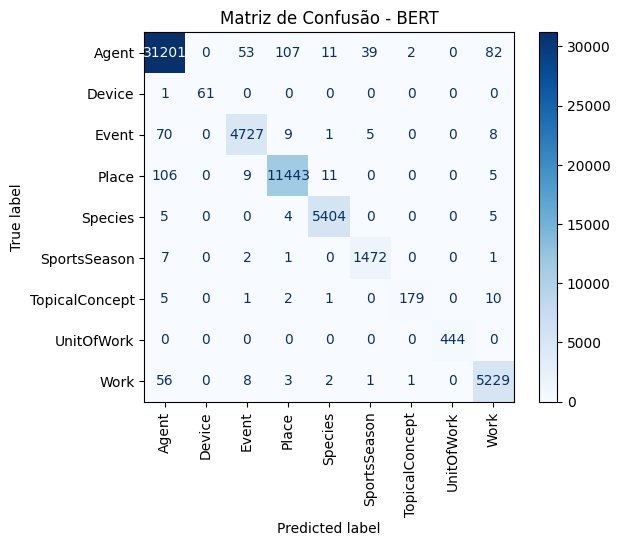

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# obter previsoes e rotulos reais
true_labels = []
pred_labels = []

for x, y in test_classifier_ds:
    preds = classifer_model.predict(x, verbose=0)
    pred_labels.extend(np.argmax(preds, axis=1))
    true_labels.extend(y.numpy())

# gerar matriz de confusao
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# plotar
plt.figure(figsize=(10, 10))
disp.plot(xticks_rotation="vertical", cmap="Blues", values_format='d')
plt.title("Matriz de Confusão - BERT")
plt.show()

In [15]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, pred_labels, target_names=label_encoder.classes_))

                precision    recall  f1-score   support

         Agent       0.99      0.99      0.99     31495
        Device       1.00      0.98      0.99        62
         Event       0.98      0.98      0.98      4820
         Place       0.99      0.99      0.99     11574
       Species       1.00      1.00      1.00      5418
  SportsSeason       0.97      0.99      0.98      1483
TopicalConcept       0.98      0.90      0.94       198
    UnitOfWork       1.00      1.00      1.00       444
          Work       0.98      0.99      0.98      5300

      accuracy                           0.99     60794
     macro avg       0.99      0.98      0.98     60794
  weighted avg       0.99      0.99      0.99     60794



---

EQUIPE:

⇒ O modelo BERT apresentou um desempenho bastante robusto com:
- Acurácia global de 99.7%
- F1-score médio ponderado de 99%

⇒ Principais destaques:
- Classes majoritárias como "Agent", "Device", "Place", "Species" e "UnitOfWork" tiveram excelente desempenho, com F1-score acima de 99%.
- No entanto, o modelo apresentou ligeira queda de desempenho em classes minoritárias, especialmente:
  - "TopicalConcept": F1-score de 94%

⇒ Essa queda pode estar relacionada ao desequilíbrio nas amostras e à dificuldade de distinguir essas classes em relação a outras semanticamente próximas, como "Event" ou "SportsSeason".

---